In [13]:
import logging
import os
import sys
from dataclasses import dataclass, field
from typing import Optional

import torch
from datasets import load_dataset
from torchvision.transforms import Compose, Lambda, Normalize, RandomHorizontalFlip, RandomResizedCrop, ToTensor, RandomPerspective, Resize, RandomAdjustSharpness, RandomAutocontrast, RandomGrayscale, GaussianBlur
from torchvision.transforms.functional import InterpolationMode

import transformers
from transformers import (
    HfArgumentParser,
    Trainer,
    TrainingArguments,
    ViTFeatureExtractor,
    ViTMAEConfig,
    ViTMAEForPreTraining,
)
from transformers.trainer_utils import get_last_checkpoint
from transformers.utils import check_min_version, send_example_telemetry
from transformers.utils.versions import require_version

In [14]:
'''
Base model size so we can capture more in a vector
'''
configuration = ViTMAEConfig(
    patch_size = 16,
    image_size = 384,
    mask_ratio = 0.6,
    norm_pix_loss = True,
    hidden_dropout_prob = 0.05,
    attention_probs_dropout_prob = 0.05,
    decoder_num_hidden_layers= 4,
    decoder_num_attention_heads = 4,
    decoder_hidden_size = 256,
    decoder_intermediate_size = 1024
)

In [15]:
feature_extractor = ViTFeatureExtractor(
    size = 384
)

In [16]:
model = ViTMAEForPreTraining(configuration)

In [17]:
feature_extractor.size

{'height': 384, 'width': 384}

In [18]:
if "shortest_edge" in feature_extractor.size:
  size = feature_extractor.size["shortest_edge"]
else:
  size = (feature_extractor.size["height"], feature_extractor.size["width"])

In [19]:
size

(384, 384)

In [20]:
ds = load_dataset("cifar10")

In [21]:
ds.keys()

dict_keys(['train', 'test'])

In [22]:
column_names = ds["train"].column_names
image_column_name = column_names[0]
print(image_column_name)

img


In [23]:
# transformations as done in original MAE paper
# source: https://github.com/facebookresearch/mae/blob/main/main_pretrain.py
transforms = Compose(
    [
        Lambda(lambda img: img.convert("RGB") if img.mode != "RGB" else img),
        # Resize(feature_extractor.size, interpolation=InterpolationMode.BICUBIC),
        RandomPerspective(distortion_scale=0.45, p=0.15),
        GaussianBlur(kernel_size=(5, 9), sigma=(0.01,2.0)),
        RandomAdjustSharpness(sharpness_factor=0.35, p=0.25),
        ToTensor(),
        Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
    ]
)

def preprocess_images(examples):
    """Preprocess a batch of images by applying transforms."""
    examples["pixel_values"] = [transforms(image) for image in examples[image_column_name]]
    return examples

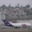

In [24]:
ds['train']['img'][0]

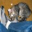

In [25]:
ds['test']['img'][0]

In [26]:
ds["train"].set_transform(preprocess_images)
ds["test"].set_transform(preprocess_images)

In [27]:
'''
https://github.com/huggingface/transformers/issues/19802
You'll need to add remove_unused_columns=False to the TrainingArguments.

The reason is because of the use of set_transform when preparing the datasets, which does things on-the-fly.
Hence we still need to image column in the datasets to turn them into pixel_values.
'''

"\nhttps://github.com/huggingface/transformers/issues/19802\nYou'll need to add remove_unused_columns=False to the TrainingArguments.\n\nThe reason is because of the use of set_transform when preparing the datasets, which does things on-the-fly.\nHence we still need to image column in the datasets to turn them into pixel_values.\n"

In [28]:
def get_training_args(output_dir: str, overwrite_output_dir : bool = True, batch_size : int = 128, num_epochs: int = 10):
    return TrainingArguments(
        output_dir = output_dir,
        overwrite_output_dir = overwrite_output_dir,
        per_device_train_batch_size = batch_size,
        num_train_epochs = num_epochs,
        learning_rate=1.5e-4,
        warmup_ratio = 0.05,
        logging_strategy = 'epoch',
        evaluation_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        save_total_limit = 100,
        run_name="vit-mae-test",
        remove_unused_columns=False,
        tf32=True,
        dataloader_num_workers = os.cpu_count(),
        optim="adamw_torch",
        lr_scheduler_type="cosine",
        weight_decay=0.05,
    )

In [30]:
training_args = TrainingArguments(output_dir = "./test",
             overwrite_output_dir = True,
             per_device_train_batch_size = 8,
             num_train_epochs = 100,
             learning_rate=1.5e-4,
             warmup_ratio = 0.05,
             logging_strategy = 'epoch',
              evaluation_strategy='epoch',
              save_strategy='epoch',
              load_best_model_at_end=True,
              save_total_limit = 100,
              run_name="vit-mae-test",
              remove_unused_columns=False,
              tf32=False,
              dataloader_num_workers = os.cpu_count(),
              optim="adamw_torch",
              lr_scheduler_type="cosine",
              weight_decay=0.05,
          )

# Compute absolute learning rate
total_train_batch_size = (
    training_args.train_batch_size * training_args.gradient_accumulation_steps * training_args.world_size
)
training_args.learning_rate = training_args.learning_rate * total_train_batch_size / 256

In [31]:
training_args.world_size

1

In [32]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    return {"pixel_values": pixel_values}

In [33]:
# Initialize our trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    tokenizer=feature_extractor,
    data_collator=collate_fn,
)

In [ ]:
#more gradient updates seem to work - gradient accumulation might be hurting
# 24 layers isn't better all the time
# 24 attention heads is worse than 6 attention heads

In [34]:
#75% masking 12 layers, 12 attention heads, 16 patch size, decoder with 4 attention heads and 2 layers 192 batch size
trainer.train()

  0%|          | 0/625000 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/lenn/opt/anaconda3/envs/neuralnet311/lib/python3.11/multiprocessing/spawn.py", line 120, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/lenn/opt/anaconda3/envs/neuralnet311/lib/python3.11/multiprocessing/spawn.py", line 130, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'preprocess_images' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/lenn/opt/anaconda3/envs/neuralnet311/lib/python3.11/multiprocessing/spawn.py", line 120, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/lenn/opt/anaconda3/envs/neuralnet311/lib/python3.11/multiprocessing/spawn.py", line 130, in _main
    self = reduction.pickle.load(from_pa

RuntimeError: DataLoader worker (pid(s) 80078) exited unexpectedly

In [ ]:
#75% masking 12 layers, 12 attention heads, 24 patch size, decoder with 4 attention heads and 2 layers 384 batch size
trainer.train()

***** Running training *****
  Num examples = 50000
  Num Epochs = 10
  Instantaneous batch size per device = 384
  Total train batch size (w. parallel, distributed & accumulation) = 384
  Gradient Accumulation steps = 1
  Total optimization steps = 1310
  Number of trainable parameters = 88605888


Epoch,Training Loss,Validation Loss
1,0.806000,0.662734
2,0.613300,0.575301
3,0.567500,0.563053
4,0.549400,0.532238
5,0.521400,0.505097
6,0.501300,0.486622
7,0.483900,0.468811
8,0.473500,0.460322
9,0.467500,0.455817
10,0.465500,0.454984


***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-131
Configuration saved in test-vit/checkpoint-131/config.json
Model weights saved in test-vit/checkpoint-131/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-131/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-262
Configuration saved in test-vit/checkpoint-262/config.json
Model weights saved in test-vit/checkpoint-262/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-262/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-393
Configuration saved in test-vit/checkpoint-393/config.json
Model weights saved in test-vit/checkpoint-393/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-393/preprocessor_config.json
***** Running Evaluation *****
  N

TrainOutput(global_step=1310, training_loss=0.5449381296871273, metrics={'train_runtime': 2472.0194, 'train_samples_per_second': 202.264, 'train_steps_per_second': 0.53, 'total_flos': 1.17938479693824e+20, 'train_loss': 0.5449381296871273, 'epoch': 10.0})

In [ ]:
#75% masking 12 layers, 12 attention heads, decoder with 4 attention heads and 2 layers 192 batch size
trainer.train()

***** Running training *****
  Num examples = 50000
  Num Epochs = 10
  Instantaneous batch size per device = 192
  Total train batch size (w. parallel, distributed & accumulation) = 192
  Gradient Accumulation steps = 1
  Total optimization steps = 2610
  Number of trainable parameters = 87621888


Epoch,Training Loss,Validation Loss
1,0.721300,0.574548
2,0.510900,0.466157
3,0.462900,0.451724
4,0.441900,0.421916
5,0.403900,0.382665
6,0.371600,0.343169
7,0.345000,0.321825
8,0.332600,0.312614
9,0.326500,0.308952
10,0.324700,0.308087


***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-261
Configuration saved in test-vit/checkpoint-261/config.json
Model weights saved in test-vit/checkpoint-261/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-261/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-522
Configuration saved in test-vit/checkpoint-522/config.json
Model weights saved in test-vit/checkpoint-522/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-522/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-783
Configuration saved in test-vit/checkpoint-783/config.json
Model weights saved in test-vit/checkpoint-783/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-783/preprocessor_config.json
***** Running Evaluation *****
  N

TrainOutput(global_step=2610, training_loss=0.42411637287943754, metrics={'train_runtime': 1638.4045, 'train_samples_per_second': 305.175, 'train_steps_per_second': 1.593, 'total_flos': 1.17067474796544e+20, 'train_loss': 0.42411637287943754, 'epoch': 10.0})

In [ ]:
#75% masking 12 layers, 6 attention heads, 24 patch, decoder with 4 attention heads and 2 layers - can use 640 batch size
trainer.train()

***** Running training *****
  Num examples = 50000
  Num Epochs = 10
  Instantaneous batch size per device = 640
  Total train batch size (w. parallel, distributed & accumulation) = 640
  Gradient Accumulation steps = 1
  Total optimization steps = 790
  Number of trainable parameters = 24081600


Epoch,Training Loss,Validation Loss
1,0.824300,0.718923


***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-79
Configuration saved in test-vit/checkpoint-79/config.json
Model weights saved in test-vit/checkpoint-79/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-79/preprocessor_config.json


KeyboardInterrupt: ignored

In [ ]:
#75% masking 12 layers, 6 attention heads, decoder with 4 attention heads and 2 layers - can use 256 batch size
trainer.train()

***** Running training *****
  Num examples = 50000
  Num Epochs = 10
  Instantaneous batch size per device = 256
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 1
  Total optimization steps = 1960
  Number of trainable parameters = 23466240


Epoch,Training Loss,Validation Loss
1,0.734300,0.553461
2,0.503800,0.471630
3,0.465500,0.452548
4,0.431800,0.405063
5,0.391400,0.362184
6,0.356400,0.332269
7,0.336800,0.315196
8,0.325500,0.306295
9,0.319800,0.302081
10,0.318300,0.301795


***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-196
Configuration saved in test-vit/checkpoint-196/config.json
Model weights saved in test-vit/checkpoint-196/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-196/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-392
Configuration saved in test-vit/checkpoint-392/config.json
Model weights saved in test-vit/checkpoint-392/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-392/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-588
Configuration saved in test-vit/checkpoint-588/config.json
Model weights saved in test-vit/checkpoint-588/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-588/preprocessor_config.json
***** Running Evaluation *****
  N

TrainOutput(global_step=1960, training_loss=0.41836337070075835, metrics={'train_runtime': 1224.2545, 'train_samples_per_second': 408.412, 'train_steps_per_second': 1.601, 'total_flos': 3.163221393408e+19, 'train_loss': 0.41836337070075835, 'epoch': 10.0})

In [ ]:
#12 layers, 6 attention heads, decoder with 4 attention heads and 2 layers - can use 192 batch size
trainer.train()

***** Running training *****
  Num examples = 50000
  Num Epochs = 10
  Instantaneous batch size per device = 192
  Total train batch size (w. parallel, distributed & accumulation) = 192
  Gradient Accumulation steps = 1
  Total optimization steps = 2610
  Number of trainable parameters = 23466240


Epoch,Training Loss,Validation Loss
1,0.721600,0.529469
2,0.488200,0.455943
3,0.452100,0.434037
4,0.400200,0.370430
5,0.363800,0.339253
6,0.336700,0.308669
7,0.314500,0.290110
8,0.301700,0.279971
9,0.295000,0.275347
10,0.293100,0.274801


***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-261
Configuration saved in test-vit/checkpoint-261/config.json
Model weights saved in test-vit/checkpoint-261/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-261/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-522
Configuration saved in test-vit/checkpoint-522/config.json
Model weights saved in test-vit/checkpoint-522/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-522/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-783
Configuration saved in test-vit/checkpoint-783/config.json
Model weights saved in test-vit/checkpoint-783/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-783/preprocessor_config.json
***** Running Evaluation *****
  N

TrainOutput(global_step=2610, training_loss=0.3966947504387048, metrics={'train_runtime': 1422.2928, 'train_samples_per_second': 351.545, 'train_steps_per_second': 1.835, 'total_flos': 3.163221393408e+19, 'train_loss': 0.3966947504387048, 'epoch': 10.0})

In [ ]:
# 24 layers encoder - 128 batch size
# test - decoder with 4 attention heads if you check the config the decoder hiddne size, intermediate size is the same rate as encoder per head!
trainer.train()

***** Running training *****
  Num examples = 50000
  Num Epochs = 10
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 3910
  Number of trainable parameters = 44759808


Epoch,Training Loss,Validation Loss
1,0.699700,0.522085
2,0.482000,0.454478
3,0.433400,0.396622
4,0.378300,0.342505
5,0.333100,0.300412
6,0.304600,0.280157
7,0.289300,0.265880
8,0.280600,0.259355
9,0.276200,0.255832
10,0.274300,0.255388


***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-391
Configuration saved in test-vit/checkpoint-391/config.json
Model weights saved in test-vit/checkpoint-391/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-391/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-782
Configuration saved in test-vit/checkpoint-782/config.json
Model weights saved in test-vit/checkpoint-782/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-782/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-1173
Configuration saved in test-vit/checkpoint-1173/config.json
Model weights saved in test-vit/checkpoint-1173/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-1173/preprocessor_config.json
***** Running Evaluation *****

TrainOutput(global_step=3910, training_loss=0.37514540143025193, metrics={'train_runtime': 2232.869, 'train_samples_per_second': 223.927, 'train_steps_per_second': 1.751, 'total_flos': 5.9890993201152e+19, 'train_loss': 0.37514540143025193, 'epoch': 10.0})

In [ ]:
# 16 patch, 6 attention heads, 2 layer decoder, 24 layers encoder
# random perspective augmentation + random adjust sharpness 0.38 sharpess factor
# 60% masking ratio + hyperparams in original implementation like cosine learning rate scheduling
# dataload_num_workers = 12 - does it beat 1.76 it/s? -> YES IT DOES!
# for two GPUs we want dataload_num_workers = 24 probably
# 4 attention heads encoder, even smaller decoder with 16 patch size can do:
trainer.train()

***** Running training *****
  Num examples = 50000
  Num Epochs = 10
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 3910
  Number of trainable parameters = 43996032


Epoch,Training Loss,Validation Loss
1,0.723900,0.592738
2,0.522200,0.479779
3,0.467000,0.453773
4,0.441900,0.409960
5,0.401400,0.382229
6,0.380800,0.362736
7,0.368800,0.352512
8,0.357600,0.339509
9,0.348400,0.332841
10,0.345700,0.332397


***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-391
Configuration saved in test-vit/checkpoint-391/config.json
Model weights saved in test-vit/checkpoint-391/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-391/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-782
Configuration saved in test-vit/checkpoint-782/config.json
Model weights saved in test-vit/checkpoint-782/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-782/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-1173
Configuration saved in test-vit/checkpoint-1173/config.json
Model weights saved in test-vit/checkpoint-1173/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-1173/preprocessor_config.json
***** Running Evaluation *****
  

TrainOutput(global_step=3910, training_loss=0.43576326492192496, metrics={'train_runtime': 2030.8422, 'train_samples_per_second': 246.203, 'train_steps_per_second': 1.925, 'total_flos': 5.8828375719936e+19, 'train_loss': 0.43576326492192496, 'epoch': 10.0})

In [ ]:
# 16 patch, 6 attention heads, 2 layer decoder, no gradient accumulation
# random perspective augmentation + random adjust sharpness 0.38 sharpess factor
# 60% masking ratio + hyperparams in original implementation like cosine learning rate scheduling
# dataload_num_workers = 12 - does it beat 1.76 it/s? -> YES IT DOES!
# for two GPUs we want dataload_num_workers = 24 probably
# 4 attention heads encoder, even smaller decoder with 16 patch size can do:
trainer.train()

***** Running training *****
  Num examples = 50000
  Num Epochs = 10
  Instantaneous batch size per device = 192
  Total train batch size (w. parallel, distributed & accumulation) = 192
  Gradient Accumulation steps = 1
  Total optimization steps = 2610
  Number of trainable parameters = 22702464


Epoch,Training Loss,Validation Loss
1,0.736200,0.597744
2,0.538000,0.489775
3,0.472600,0.457702
4,0.452800,0.441118
5,0.434000,0.405080
6,0.398900,0.378281
7,0.383700,0.366899
8,0.375800,0.361469
9,0.371300,0.356990
10,0.370100,0.357004


***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-261
Configuration saved in test-vit/checkpoint-261/config.json
Model weights saved in test-vit/checkpoint-261/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-261/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-522
Configuration saved in test-vit/checkpoint-522/config.json
Model weights saved in test-vit/checkpoint-522/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-522/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-783
Configuration saved in test-vit/checkpoint-783/config.json
Model weights saved in test-vit/checkpoint-783/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-783/preprocessor_config.json
***** Running Evaluation *****
  Num 

TrainOutput(global_step=2610, training_loss=0.45335129193419244, metrics={'train_runtime': 1302.4163, 'train_samples_per_second': 383.902, 'train_steps_per_second': 2.004, 'total_flos': 3.0569596452864e+19, 'train_loss': 0.45335129193419244, 'epoch': 10.0})

In [ ]:
# 16 patch, 6 attention heads, no gradient accumulation
# random perspective augmentation + random adjust sharpness 0.38 sharpess factor
# 60% masking ratio + hyperparams in original implementation like cosine learning rate scheduling
# dataload_num_workers = 12 - does it beat 1.76 it/s? -> YES IT DOES!
# for two GPUs we want dataload_num_workers = 24 probably
# 4 attention heads encoder, even smaller decoder with 16 patch size can do:
trainer.train()

***** Running training *****
  Num examples = 50000
  Num Epochs = 10
  Instantaneous batch size per device = 96
  Total train batch size (w. parallel, distributed & accumulation) = 192
  Gradient Accumulation steps = 2
  Total optimization steps = 2600
  Number of trainable parameters = 25371648


Epoch,Training Loss,Validation Loss
0,0.724100,0.570632
1,0.497800,0.459864
2,0.453600,0.441771
3,0.422000,0.381374
4,0.384100,0.362904
5,0.341900,0.303518
6,0.305000,0.269545
7,0.284600,0.259065


***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-260
Configuration saved in test-vit/checkpoint-260/config.json
Model weights saved in test-vit/checkpoint-260/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-260/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-520
Configuration saved in test-vit/checkpoint-520/config.json
Model weights saved in test-vit/checkpoint-520/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-520/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-780
Configuration saved in test-vit/checkpoint-780/config.json
Model weights saved in test-vit/checkpoint-780/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-780/preprocessor_config.json
***** Running Evaluation *****
  Num 

KeyboardInterrupt: ignored

In [ ]:
# 16 patch, 6 attention heads, no gradient accumulation
# random perspective augmentation + random adjust sharpness 0.38 sharpess factor
# 60% masking ratio + hyperparams in original implementation like cosine learning rate scheduling
# dataload_num_workers = 12 - does it beat 1.76 it/s? -> YES IT DOES!
# for two GPUs we want dataload_num_workers = 24 probably
# 4 attention heads encoder, even smaller decoder with 16 patch size can do:
trainer.train()

***** Running training *****
  Num examples = 50000
  Num Epochs = 10
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 7820
  Number of trainable parameters = 25371648


Epoch,Training Loss,Validation Loss
1,0.689500,0.515039
2,0.473000,0.448987


***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-782
Configuration saved in test-vit/checkpoint-782/config.json
Model weights saved in test-vit/checkpoint-782/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-782/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-1564
Configuration saved in test-vit/checkpoint-1564/config.json
Model weights saved in test-vit/checkpoint-1564/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-1564/preprocessor_config.json


KeyboardInterrupt: ignored

In [ ]:
# 8 patch, 6 attention heads, 24 layers
# random perspective augmentation + random adjust sharpness 0.38 sharpess factor
# 60% masking ratio + hyperparams in original implementation like cosine learning rate scheduling
# dataload_num_workers = 12 - does it beat 1.76 it/s? -> YES IT DOES!
# for two GPUs we want dataload_num_workers = 24 probably
# 4 attention heads encoder, even smaller decoder with 16 patch size can do:
trainer.train()

***** Running training *****
  Num examples = 50000
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 8
  Total optimization steps = 7810
  Number of trainable parameters = 46332864


Epoch,Training Loss,Validation Loss
0,0.643900,0.485830
1,0.389600,0.324134
2,0.319300,0.304766
3,0.306000,0.295680


***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-781
Configuration saved in test-vit/checkpoint-781/config.json
Model weights saved in test-vit/checkpoint-781/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-781/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-1562
Configuration saved in test-vit/checkpoint-1562/config.json
Model weights saved in test-vit/checkpoint-1562/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-1562/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-2343
Configuration saved in test-vit/checkpoint-2343/config.json
Model weights saved in test-vit/checkpoint-2343/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-2343/preprocessor_config.json
***** Running Evaluation ****

KeyboardInterrupt: ignored

In [ ]:
# 16 patch, 4 attention heads NO gradient accumulation
# random perspective augmentation + random adjust sharpness 0.38 sharpess factor
# 60% masking ratio + hyperparams in original implementation like cosine learning rate scheduling
# dataload_num_workers = 12 - does it beat 1.76 it/s? -> YES IT DOES!
# for two GPUs we want dataload_num_workers = 24 probably
# 4 attention heads encoder, even smaller decoder with 16 patch size can do:
trainer.train()

***** Running training *****
  Num examples = 50000
  Num Epochs = 10
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 3910
  Number of trainable parameters = 11393280


Epoch,Training Loss,Validation Loss
1,0.735500,0.593544
2,0.521900,0.471758
3,0.463000,0.450575
4,0.447900,0.437822
5,0.430100,0.394753
6,0.392300,0.374182
7,0.380500,0.364559
8,0.372900,0.357252
9,0.362600,0.342556
10,0.356400,0.340533


***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-391
Configuration saved in test-vit/checkpoint-391/config.json
Model weights saved in test-vit/checkpoint-391/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-391/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-782
Configuration saved in test-vit/checkpoint-782/config.json
Model weights saved in test-vit/checkpoint-782/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-782/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-1173
Configuration saved in test-vit/checkpoint-1173/config.json
Model weights saved in test-vit/checkpoint-1173/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-1173/preprocessor_config.json
***** Running Evaluation *****
  

TrainOutput(global_step=3910, training_loss=0.44629948998961, metrics={'train_runtime': 1637.7505, 'train_samples_per_second': 305.297, 'train_steps_per_second': 2.387, 'total_flos': 1.5414111240192e+19, 'train_loss': 0.44629948998961, 'epoch': 10.0})

In [ ]:
# 16 patch, 6 attention heads NO gradient accumulation
# random perspective augmentation + random adjust sharpness 0.38 sharpess factor
# 60% masking ratio + hyperparams in original implementation like cosine learning rate scheduling
# dataload_num_workers = 12 - does it beat 1.76 it/s? -> YES IT DOES!
# for two GPUs we want dataload_num_workers = 24 probably
# 4 attention heads encoder, even smaller decoder with 16 patch size can do:
trainer.train()

***** Running training *****
  Num examples = 50000
  Num Epochs = 10
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 7820
  Number of trainable parameters = 25371648


Epoch,Training Loss,Validation Loss
1,0.691800,0.520951
2,0.476700,0.449636
3,0.421800,0.381310
4,0.377500,0.338242
5,0.327900,0.288414
6,0.295800,0.265134
7,0.280100,0.251427
8,0.271200,0.246482
9,0.267100,0.242409
10,0.265500,0.241822


***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-782
Configuration saved in test-vit/checkpoint-782/config.json
Model weights saved in test-vit/checkpoint-782/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-782/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-1564
Configuration saved in test-vit/checkpoint-1564/config.json
Model weights saved in test-vit/checkpoint-1564/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-1564/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-2346
Configuration saved in test-vit/checkpoint-2346/config.json
Model weights saved in test-vit/checkpoint-2346/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-2346/preprocessor_config.json
***** Running Evaluation ****

TrainOutput(global_step=7820, training_loss=0.3675394511893582, metrics={'train_runtime': 2328.4553, 'train_samples_per_second': 214.735, 'train_steps_per_second': 3.358, 'total_flos': 3.4111881216e+19, 'train_loss': 0.3675394511893582, 'epoch': 10.0})

In [ ]:
# 16 patch, 3 attention heads NO gradient accumulation
# random perspective augmentation + random adjust sharpness 0.38 sharpess factor
# 60% masking ratio + hyperparams in original implementation like cosine learning rate scheduling
# dataload_num_workers = 12 - does it beat 1.76 it/s? -> YES IT DOES!
# for two GPUs we want dataload_num_workers = 24 probably
# 4 attention heads encoder, even smaller decoder with 16 patch size can do:

'''
configuration = ViTMAEConfig(
    patch_size = 16,
    image_size = 384,
    mask_ratio = 0.6,
    norm_pix_loss = True,
    hidden_dropout_prob = 0.05,
    attention_probs_dropout_prob = 0.05,
    hidden_size = 256,
    num_attention_heads = 4,
    intermediate_size = 1024,
    decoder_num_attention_heads = 4,
    decoder_hidden_size = 128,
    decoder_intermediate_size = 512
)
'''
'''
batch_size : int = 192
'''
'''
decoder_num_attention_heads = 3,
decoder_hidden_size = 96,
decoder_intermediate_size = 384
'''
trainer.train()

***** Running training *****
  Num examples = 50000
  Num Epochs = 10
  Instantaneous batch size per device = 192
  Total train batch size (w. parallel, distributed & accumulation) = 192
  Gradient Accumulation steps = 1
  Total optimization steps = 2610
  Number of trainable parameters = 6474624


Epoch,Training Loss,Validation Loss
1,0.773500,0.659215
2,0.602900,0.548964


***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-261
Configuration saved in test-vit/checkpoint-261/config.json
Model weights saved in test-vit/checkpoint-261/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-261/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-522
Configuration saved in test-vit/checkpoint-522/config.json
Model weights saved in test-vit/checkpoint-522/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-522/preprocessor_config.json


KeyboardInterrupt: ignored

In [ ]:
# 16 patch, 3 attention heads
# random perspective augmentation + random adjust sharpness 0.38 sharpess factor
# 60% masking ratio + hyperparams in original implementation like cosine learning rate scheduling
# dataload_num_workers = 12 - does it beat 1.76 it/s? -> YES IT DOES!
# for two GPUs we want dataload_num_workers = 24 probably
# 4 attention heads encoder, even smaller decoder with 16 patch size can do:

'''
configuration = ViTMAEConfig(
    patch_size = 16,
    image_size = 384,
    mask_ratio = 0.6,
    norm_pix_loss = True,
    hidden_dropout_prob = 0.05,
    attention_probs_dropout_prob = 0.05,
    hidden_size = 256,
    num_attention_heads = 4,
    intermediate_size = 1024,
    decoder_num_attention_heads = 4,
    decoder_hidden_size = 128,
    decoder_intermediate_size = 512
)
'''
'''
batch_size : int = 192
'''
'''
decoder_num_attention_heads = 3,
decoder_hidden_size = 96,
decoder_intermediate_size = 384
'''
trainer.train()

***** Running training *****
  Num examples = 50000
  Num Epochs = 10
  Instantaneous batch size per device = 192
  Total train batch size (w. parallel, distributed & accumulation) = 3072
  Gradient Accumulation steps = 16
  Total optimization steps = 160


Epoch,Training Loss,Validation Loss
0,0.913700,0.813010
1,0.785600,0.743591
2,0.763500,0.766983
3,0.792500,0.775378
4,0.755700,0.727494
5,0.731300,0.712803
6,0.723500,0.710414
7,0.721500,0.709038
8,0.719700,0.707754
9,0.705900,0.710080


***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-16
Configuration saved in test-vit/checkpoint-16/config.json
Model weights saved in test-vit/checkpoint-16/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-16/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-32
Configuration saved in test-vit/checkpoint-32/config.json
Model weights saved in test-vit/checkpoint-32/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-32/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-48
Configuration saved in test-vit/checkpoint-48/config.json
Model weights saved in test-vit/checkpoint-48/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-48/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4

TrainOutput(global_step=160, training_loss=0.7612976551055908, metrics={'train_runtime': 1168.8065, 'train_samples_per_second': 427.787, 'train_steps_per_second': 0.137, 'total_flos': 8.798085340515533e+18, 'train_loss': 0.7612976551055908, 'epoch': 9.98})

In [ ]:
# 16 patch
# random perspective augmentation + random adjust sharpness 0.38 sharpess factor
# 60% masking ratio + hyperparams in original implementation like cosine learning rate scheduling
# dataload_num_workers = 12 - does it beat 1.76 it/s? -> YES IT DOES!
# for two GPUs we want dataload_num_workers = 24 probably
# 4 attention heads encoder, even smaller decoder with 16 patch size can do:

'''
configuration = ViTMAEConfig(
    patch_size = 16,
    image_size = 384,
    mask_ratio = 0.6,
    norm_pix_loss = True,
    hidden_dropout_prob = 0.05,
    attention_probs_dropout_prob = 0.05,
    hidden_size = 256,
    num_attention_heads = 4,
    intermediate_size = 1024,
    decoder_num_attention_heads = 4,
    decoder_hidden_size = 128,
    decoder_intermediate_size = 512
)
'''
'''
batch_size : int = 192
'''
'''
decoder_num_attention_heads = 3,
decoder_hidden_size = 96,
decoder_intermediate_size = 384
'''
trainer.train()

***** Running training *****
  Num examples = 50000
  Num Epochs = 10
  Instantaneous batch size per device = 192
  Total train batch size (w. parallel, distributed & accumulation) = 3072
  Gradient Accumulation steps = 16
  Total optimization steps = 160


Epoch,Training Loss,Validation Loss
0,0.909200,0.790385
1,0.782100,0.753281
2,0.760300,0.737416
3,0.746200,0.724553
4,0.733300,0.719171


***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-16
Configuration saved in test-vit/checkpoint-16/config.json
Model weights saved in test-vit/checkpoint-16/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-16/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-32
Configuration saved in test-vit/checkpoint-32/config.json
Model weights saved in test-vit/checkpoint-32/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-32/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-48
Configuration saved in test-vit/checkpoint-48/config.json
Model weights saved in test-vit/checkpoint-48/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-48/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4

KeyboardInterrupt: ignored

In [ ]:
# 16 patch
# random perspective augmentation + random adjust sharpness 0.38 sharpess factor
# 60% masking ratio + hyperparams in original implementation like cosine learning rate scheduling
# dataload_num_workers = 12 - does it beat 1.76 it/s? -> YES IT DOES!
# for two GPUs we want dataload_num_workers = 24 probably
# 4 attention heads encoder, even smaller decoder with 16 patch size can do:

'''
configuration = ViTMAEConfig(
    patch_size = 16,
    image_size = 384,
    mask_ratio = 0.6,
    norm_pix_loss = True,
    hidden_dropout_prob = 0.05,
    attention_probs_dropout_prob = 0.05,
    hidden_size = 256,
    num_attention_heads = 4,
    intermediate_size = 1024,
    decoder_num_attention_heads = 4,
    decoder_hidden_size = 128,
    decoder_intermediate_size = 512
)
'''
'''
batch_size : int = 192
'''
'''
decoder_num_attention_heads = 3,
decoder_hidden_size = 96,
decoder_intermediate_size = 384
'''
trainer.train()

***** Running training *****
  Num examples = 50000
  Num Epochs = 10
  Instantaneous batch size per device = 192
  Total train batch size (w. parallel, distributed & accumulation) = 3072
  Gradient Accumulation steps = 16
  Total optimization steps = 160


Epoch,Training Loss,Validation Loss
0,0.882000,0.796675
1,0.804900,0.734464
2,0.743800,0.746208
3,0.833700,0.822157
4,0.858300,0.863542
5,0.877200,0.850637
6,0.864800,0.830015
7,0.822100,0.774627
8,0.790400,0.764449
9,0.761500,0.761620


***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-16
Configuration saved in test-vit/checkpoint-16/config.json
Model weights saved in test-vit/checkpoint-16/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-16/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-32
Configuration saved in test-vit/checkpoint-32/config.json
Model weights saved in test-vit/checkpoint-32/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-32/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-48
Configuration saved in test-vit/checkpoint-48/config.json
Model weights saved in test-vit/checkpoint-48/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-48/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4

TrainOutput(global_step=160, training_loss=0.8238676428794861, metrics={'train_runtime': 1235.566, 'train_samples_per_second': 404.673, 'train_steps_per_second': 0.129, 'total_flos': 1.4403846729432564e+19, 'train_loss': 0.8238676428794861, 'epoch': 9.98})

In [ ]:
# 16 patch
# only random perspective augmentation
# 60% masking ratio + hyperparams in original implementation like cosine learning rate scheduling
# dataload_num_workers = 12 - does it beat 1.76 it/s? -> YES IT DOES!
# for two GPUs we want dataload_num_workers = 24 probably
# 4 attention heads encoder, even smaller decoder with 16 patch size can do:

'''
configuration = ViTMAEConfig(
    patch_size = 16,
    image_size = 384,
    mask_ratio = 0.6,
    norm_pix_loss = True,
    hidden_dropout_prob = 0.05,
    attention_probs_dropout_prob = 0.05,
    hidden_size = 256,
    num_attention_heads = 4,
    intermediate_size = 1024,
    decoder_num_attention_heads = 4,
    decoder_hidden_size = 128,
    decoder_intermediate_size = 512
)
'''
'''
batch_size : int = 192
'''
'''
decoder_num_attention_heads = 3,
decoder_hidden_size = 96,
decoder_intermediate_size = 384
'''
trainer.train()

***** Running training *****
  Num examples = 50000
  Num Epochs = 10
  Instantaneous batch size per device = 192
  Total train batch size (w. parallel, distributed & accumulation) = 3072
  Gradient Accumulation steps = 16
  Total optimization steps = 160


Epoch,Training Loss,Validation Loss
0,0.880100,0.769967
1,0.756800,0.734979
2,0.761700,0.774884
3,0.796200,0.780854
4,0.786900,0.827051
5,0.780500,0.711354
6,0.722900,0.707125
7,0.718700,0.709463
8,0.717100,0.703949
9,0.704100,0.707775


***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-16
Configuration saved in test-vit/checkpoint-16/config.json
Model weights saved in test-vit/checkpoint-16/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-16/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-32
Configuration saved in test-vit/checkpoint-32/config.json
Model weights saved in test-vit/checkpoint-32/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-32/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-48
Configuration saved in test-vit/checkpoint-48/config.json
Model weights saved in test-vit/checkpoint-48/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-48/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4

TrainOutput(global_step=160, training_loss=0.7625102281570435, metrics={'train_runtime': 1226.502, 'train_samples_per_second': 407.663, 'train_steps_per_second': 0.13, 'total_flos': 1.4403846729432564e+19, 'train_loss': 0.7625102281570435, 'epoch': 9.98})

In [ ]:
# 60% masking ratio
# dataload_num_workers = 12 - does it beat 1.76 it/s? -> YES IT DOES!
# for two GPUs we want dataload_num_workers = 24 probably
# 4 attention heads encoder, even smaller decoder with 16 patch size can do:

'''
configuration = ViTMAEConfig(
    patch_size = 16,
    image_size = 384,
    mask_ratio = 0.6,
    norm_pix_loss = True,
    hidden_dropout_prob = 0.05,
    attention_probs_dropout_prob = 0.05,
    hidden_size = 256,
    num_attention_heads = 4,
    intermediate_size = 1024,
    decoder_num_attention_heads = 4,
    decoder_hidden_size = 128,
    decoder_intermediate_size = 512
)
'''
'''
batch_size : int = 192
'''
'''
decoder_num_attention_heads = 3,
decoder_hidden_size = 96,
decoder_intermediate_size = 384
'''
trainer.train()

***** Running training *****
  Num examples = 50000
  Num Epochs = 10
  Instantaneous batch size per device = 192
  Total train batch size (w. parallel, distributed & accumulation) = 192
  Gradient Accumulation steps = 1
  Total optimization steps = 2610


Epoch,Training Loss,Validation Loss
1,0.667600,0.617691
2,0.494500,0.442654
3,0.419800,0.385528
4,0.373100,0.354898
5,0.345900,0.324455
6,0.313900,0.287452
7,0.288600,0.271211
8,0.276300,0.259600
9,0.267900,0.250975
10,0.262200,0.247330


***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-261
Configuration saved in test-vit/checkpoint-261/config.json
Model weights saved in test-vit/checkpoint-261/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-261/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-522
Configuration saved in test-vit/checkpoint-522/config.json
Model weights saved in test-vit/checkpoint-522/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-522/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-783
Configuration saved in test-vit/checkpoint-783/config.json
Model weights saved in test-vit/checkpoint-783/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-783/preprocessor_config.json
***** Running Evaluation *****
  Num 

TrainOutput(global_step=2610, training_loss=0.3709715715313323, metrics={'train_runtime': 1441.5912, 'train_samples_per_second': 346.839, 'train_steps_per_second': 1.81, 'total_flos': 1.5414111234152202e+19, 'train_loss': 0.3709715715313323, 'epoch': 10.0})

In [ ]:
# dataload_num_workers = 12 - does it beat 1.76 it/s? -> YES IT DOES!
# for two GPUs we want dataload_num_workers = 24 probably
# 3 attention heads encoder, even smaller decoder with 16 patch size can do:

'''
configuration = ViTMAEConfig(
    patch_size = 16,
    image_size = 384,
    mask_ratio = 0.6,
    norm_pix_loss = True,
    hidden_dropout_prob = 0.05,
    attention_probs_dropout_prob = 0.05,
    hidden_size = 192,
    num_attention_heads = 3,
    intermediate_size = 768,
    decoder_num_attention_heads = 3,
    decoder_hidden_size = 96,
    decoder_intermediate_size = 384
)
'''
'''
batch_size : int = 192
'''
'''
decoder_num_attention_heads = 3,
decoder_hidden_size = 96,
decoder_intermediate_size = 384
'''
trainer.train()

***** Running training *****
  Num examples = 50000
  Num Epochs = 10
  Instantaneous batch size per device = 192
  Total train batch size (w. parallel, distributed & accumulation) = 192
  Gradient Accumulation steps = 1
  Total optimization steps = 2610


Epoch,Training Loss,Validation Loss
1,0.662800,0.593521
2,0.460900,0.405403
3,0.370800,0.340977
4,0.319300,0.301016
5,0.304300,0.288528
6,0.281200,0.251449
7,0.247000,0.218862
8,0.223300,0.195648
9,0.204500,0.180604
10,0.194700,0.175687


***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-261
Configuration saved in test-vit/checkpoint-261/config.json
Model weights saved in test-vit/checkpoint-261/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-261/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-522
Configuration saved in test-vit/checkpoint-522/config.json
Model weights saved in test-vit/checkpoint-522/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-522/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-783
Configuration saved in test-vit/checkpoint-783/config.json
Model weights saved in test-vit/checkpoint-783/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-783/preprocessor_config.json
***** Running Evaluation *****
  Num 

TrainOutput(global_step=2610, training_loss=0.3268731566681259, metrics={'train_runtime': 1362.5559, 'train_samples_per_second': 366.957, 'train_steps_per_second': 1.916, 'total_flos': 8.813032373223424e+18, 'train_loss': 0.3268731566681259, 'epoch': 10.0})

In [ ]:
# 3 attention heads encoder, 3 attention heads decoder
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 50000
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 8192
  Gradient Accumulation steps = 128
  Total optimization steps = 30


Epoch,Training Loss,Validation Loss
0,4.904200,23.007744
1,7.925800,1.005459
2,1.089300,0.935803
3,0.896900,0.837603
4,0.822400,0.804329


***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-6
Configuration saved in test-vit/checkpoint-6/config.json
Model weights saved in test-vit/checkpoint-6/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-6/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-12
Configuration saved in test-vit/checkpoint-12/config.json
Model weights saved in test-vit/checkpoint-12/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-12/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4096
  Batch size = 8
Saving model checkpoint to test-vit/checkpoint-18
Configuration saved in test-vit/checkpoint-18/config.json
Model weights saved in test-vit/checkpoint-18/pytorch_model.bin
Feature extractor saved in test-vit/checkpoint-18/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4096


TrainOutput(global_step=30, training_loss=3.1277314186096192, metrics={'train_runtime': 781.5227, 'train_samples_per_second': 319.888, 'train_steps_per_second': 0.038, 'total_flos': 6.25123267779022e+18, 'train_loss': 3.1277314186096192, 'epoch': 4.98})

In [ ]:
trainer.save_model()